In [1]:
import pybaseball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.distance import euclidean
from scipy import stats

In [2]:
# removes warnings for readability
import warnings
warnings.simplefilter(action='ignore')

In [3]:
# loads all pitches from Seth Lugo in 2023
lugo = pybaseball.statcast_pitcher('2023-03-30', '2023-10-01', 607625)
# removes pitch-outs
lugo = lugo.loc[lugo['pitch_type']!='PO', :]

# Understanding how Lugo's pitches behave

In [4]:
# gets middle 50% velocities of pitches
lugo.groupby('pitch_name')['release_speed'].describe(percentiles=[.25, .75])[['25%', '75%']]

,25%,75%
pitch_name,,
4-Seam Fastball,92.6,94.40
Changeup,85.3,87.10
Curveball,78.5,80.80
Sinker,92.4,94.05
Slider,83.5,88.20
Sweeper,80.6,82.20


Text(0, 0.5, 'Vertical Movement (Ft.)')

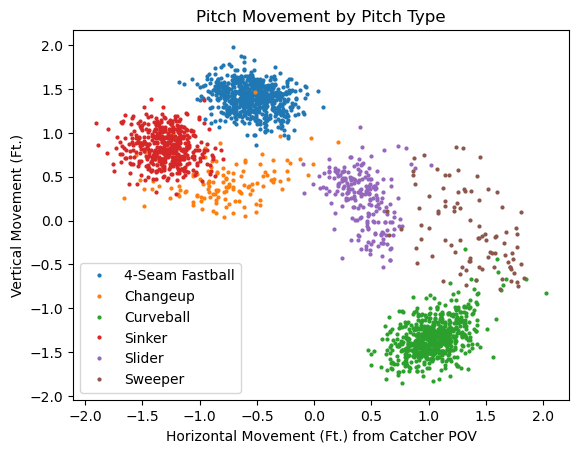

In [5]:
# plots the movement of each pitch, grouped by pitch type
groups = lugo.groupby('pitch_name')
for name, group in groups:
    plt.plot(group.pfx_x, group.pfx_z, marker='o', linestyle='', markersize=2, label=name)
plt.legend()
plt.title('Pitch Movement by Pitch Type')
plt.xlabel('Horizontal Movement (Ft.) from Catcher POV')
plt.ylabel('Vertical Movement (Ft.)')

In [6]:
# prints the percentiles of each pitch type in regards to horizontal and vertical movement
statcast = pybaseball.statcast('2023-03-30', '2023-10-01')
lugo_mean_movements = lugo.loc[:, ['pitch_type', 'pitch_name', 'pfx_x', 'pfx_z']].groupby(['pitch_type', 'pitch_name']).mean().reset_index()
mean_movements = statcast.loc[statcast['player_name']!='Lugo, Seth', ['player_name', 'pitch_type', 'pitch_name', 'pfx_x', 'pfx_z']].groupby(
    ['player_name', 'pitch_type', 'pitch_name']).mean().reset_index()
print('Pitch Movement Percentiles')
for pitch_type in lugo_mean_movements['pitch_type']:
    pitch_xbreak = mean_movements.loc[mean_movements['pitch_type']==pitch_type, 'pfx_x']
    pitch_zbreak = mean_movements.loc[mean_movements['pitch_type']==pitch_type, 'pfx_z']

    xbreak_percentile = stats.percentileofscore(pitch_xbreak, float(lugo_mean_movements.loc[(lugo_mean_movements['pitch_type']==pitch_type), 
                                                                    'pfx_x']))
    zbreak_percentile = stats.percentileofscore(pitch_xbreak, float(lugo_mean_movements.loc[(lugo_mean_movements['pitch_type']==pitch_type), 
                                                                    'pfx_z']))
    
    print(f'{pitch_type} \t xbreak: {round(xbreak_percentile, 2)} \t zbreak: {round(zbreak_percentile, 2)}')

This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 186/186 [01:17<00:00,  2.39it/s]


Pitch Movement Percentiles
CH 	 xbreak: 65.32 	 zbreak: 70.71
CU 	 xbreak: 87.36 	 zbreak: 1.44
FF 	 xbreak: 46.3 	 zbreak: 99.59
SI 	 xbreak: 31.99 	 zbreak: 75.86
SL 	 xbreak: 63.78 	 zbreak: 44.05
ST 	 xbreak: 83.68 	 zbreak: 22.63


In [7]:
# finds and prints the most similar pitches thrown by other pitchers to each of Lugo's pitch types
statcast = pybaseball.statcast('2023-03-30', '2023-10-01')
lugo_mean_movements = lugo.loc[:, ['pitch_type', 'pitch_name', 'pfx_x', 'pfx_z']].groupby(['pitch_type', 'pitch_name']).mean().reset_index()
mean_movements = statcast.loc[statcast['player_name']!='Lugo, Seth', ['player_name', 'pitch_type', 'pitch_name', 'pfx_x', 'pfx_z']].groupby(
    ['player_name', 'pitch_type', 'pitch_name']).mean().reset_index()

pitches = lugo_mean_movements['pitch_type']
pitch_names = lugo_mean_movements['pitch_name']
pfx_xs = lugo_mean_movements['pfx_x']
pfx_zs = lugo_mean_movements['pfx_z']
print('Similar Pitches')
for coords in list(map(list, zip(pfx_xs, pfx_zs, pitches, pitch_names))):
    mean_movements_pitch = mean_movements.loc[mean_movements['pitch_type']==coords[2], :]
    
    # Calculate Euclidean distances
    distances = mean_movements_pitch.apply(lambda row: euclidean([row['pfx_x'], row['pfx_z']], coords[0:2]), axis=1).sort_values()
    
    # Find the index of the minimum distance
    index_of_min_distance = distances.idxmin()
    second_most_similar_index = distances.nsmallest(2).index[1]
    
    # Get the most similar data point
    most_similar_data_point = mean_movements_pitch.loc[index_of_min_distance]
    second_most_similar_data_point = mean_movements_pitch.loc[second_most_similar_index]
    
    print(f"{coords[3]}: \t {most_similar_data_point[['player_name', 'pitch_type']].tolist()[0]} \t\t {second_most_similar_data_point[['player_name', 'pitch_type']].tolist()[0]}")


This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 186/186 [01:17<00:00,  2.39it/s]


Similar Pitches
Changeup: 	 Crowe, Wil 		 Shaw, Bryan
Curveball: 	 Brewer, Colten 		 Darvish, Yu
4-Seam Fastball: 	 Voth, Austin 		 May, Trevor
Sinker: 	 Wilson, Bryse 		 Bido, Osvaldo
Slider: 	 Jackson, Jay 		 Oviedo, Johan
Sweeper: 	 Vallimont, Chris 		 Fulmer, Michael


# Understanding how Lugo uses his pitches

In [8]:
# gets percentages of each pitch type used in all counts
lugo_lhh = dict(lugo.loc[lugo['stand']=='L', :].pitch_name.value_counts(normalize=True) * 100)
lugo_rhh = dict(lugo.loc[lugo['stand']=='R', :].pitch_name.value_counts(normalize=True) * 100)
lugo_bhh = dict(lugo.pitch_name.value_counts(normalize=True) * 100)

# turns the percentages into a dataframe
results = {}
for key in set(lugo_lhh.keys()) | set(lugo_rhh.keys()) | set(lugo_bhh.keys()):
    results[key] = [lugo_lhh.get(key, None), lugo_rhh.get(key, None), lugo_bhh.get(key, None)]
lugo_arsenal = pd.DataFrame(results).T
lugo_arsenal.columns = ['LHH', 'RHH', 'ALL']

Text(0.5, 1.0, 'vs. RHH (all counts)')

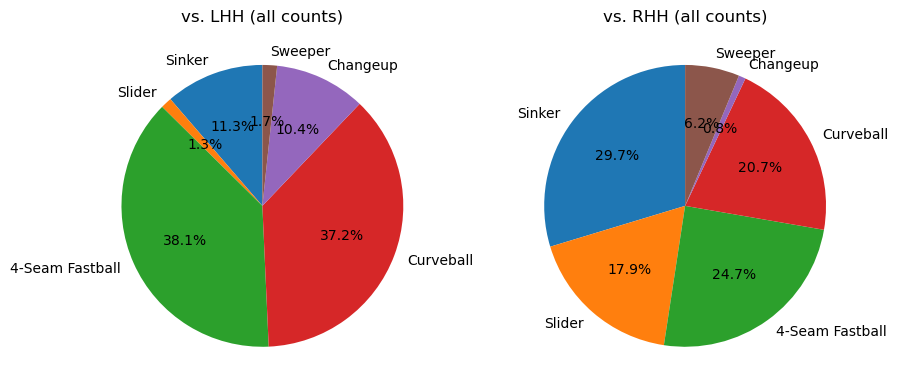

In [9]:
# displays the pitch type percentages in pie charts
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first pie chart
axes[0].pie(lugo_arsenal['LHH'], labels=lugo_arsenal.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('vs. LHH (all counts)')

# Plot the second pie chart
axes[1].pie(lugo_arsenal['RHH'], labels=lugo_arsenal.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('vs. RHH (all counts)')

In [10]:
# gets percentages of each pitch type used in 2-strike counts
lugo_lhh_2k = dict(lugo.loc[(lugo['stand']=='L') & (lugo['strikes']==2) & (lugo['balls']!=3), :].pitch_name.value_counts(normalize=True) * 100)
lugo_rhh_2k = dict(lugo.loc[(lugo['stand']=='R') & (lugo['strikes']==2) & (lugo['balls']!=3), :].pitch_name.value_counts(normalize=True) * 100)
lugo_bhh_2k = dict(lugo.loc[lugo['strikes']==2 & (lugo['balls']!=3), :].pitch_name.value_counts(normalize=True) * 100)

# turns the percentages into a dataframe
results_2k = {}
for key in set(lugo_lhh_2k.keys()) | set(lugo_rhh_2k.keys()) | set(lugo_bhh_2k.keys()):
    # Use get to handle the case where a key is not present in one of the dictionaries
    results_2k[key] = [lugo_lhh_2k.get(key, None), lugo_rhh_2k.get(key, None), lugo_bhh_2k.get(key, None)]
lugo_arsenal_2k = pd.DataFrame(results_2k).T
lugo_arsenal_2k.columns = ['LHH', 'RHH', 'ALL']

Text(0.5, 1.0, 'vs. RHH (2 strikes)')

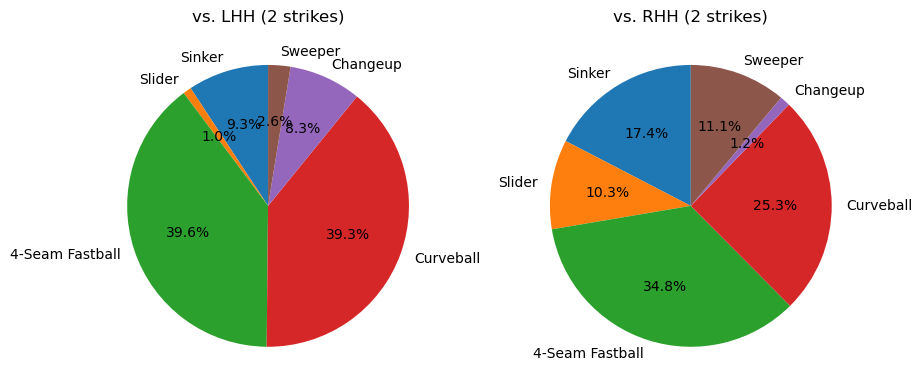

In [11]:
# displays the pitch type percentages in pie charts
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first pie chart
axes[0].pie(lugo_arsenal_2k['LHH'], labels=lugo_arsenal_2k.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('vs. LHH (2 strikes)')

# Plot the second pie chart
axes[1].pie(lugo_arsenal_2k['RHH'], labels=lugo_arsenal_2k.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('vs. RHH (2 strikes)')

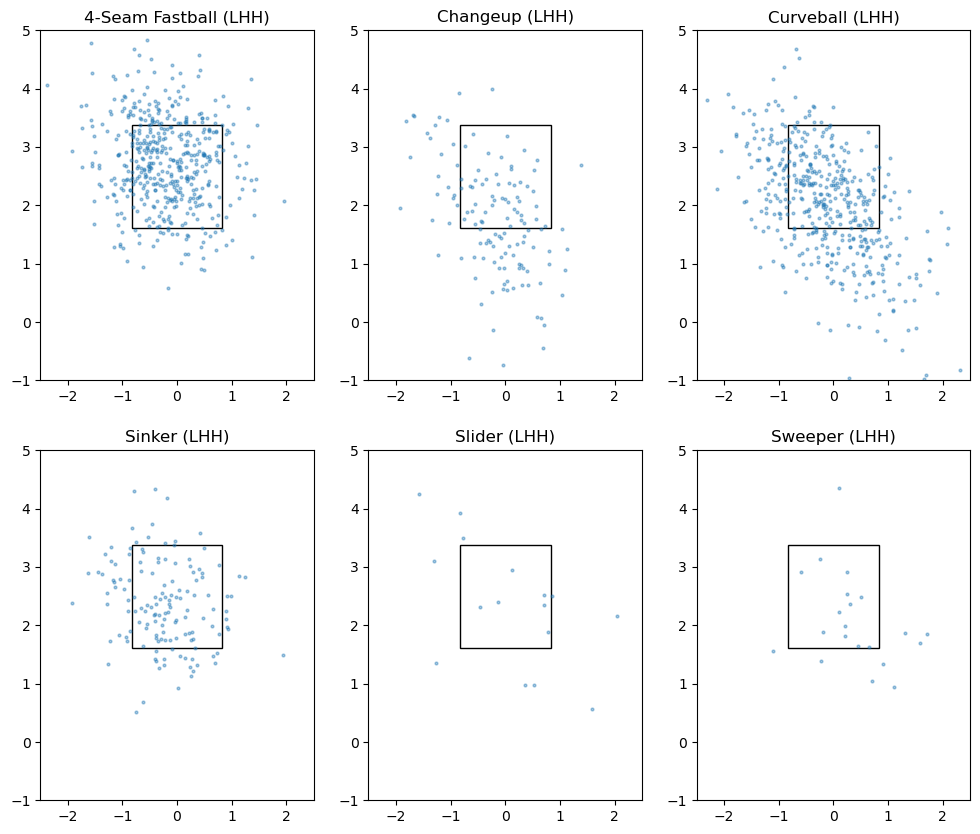

In [12]:
# plots where Lugo throws his pitches to left-handed-hitters
groups = lugo.loc[lugo['stand']=='L', :].groupby('pitch_name')
fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=False)
axes = axes.flatten()

sz_top = lugo['sz_top'].mean()
sz_bot = lugo['sz_bot'].mean()

for i, (category, group) in enumerate(groups):
    axes[i].plot(group['plate_x'], group['plate_z'], marker = 'o', linestyle='', markersize=2, alpha=0.4, label=category)
    axes[i].set_title(f'{category} (LHH)')
    axes[i].set_xlim(-2.5, 2.5)
    axes[i].set_ylim(-1, 5)
    axes[i].add_patch(patches.Rectangle((-0.83, sz_bot), 1.66, sz_top-sz_bot, linewidth=1, edgecolor='black', facecolor='none'))

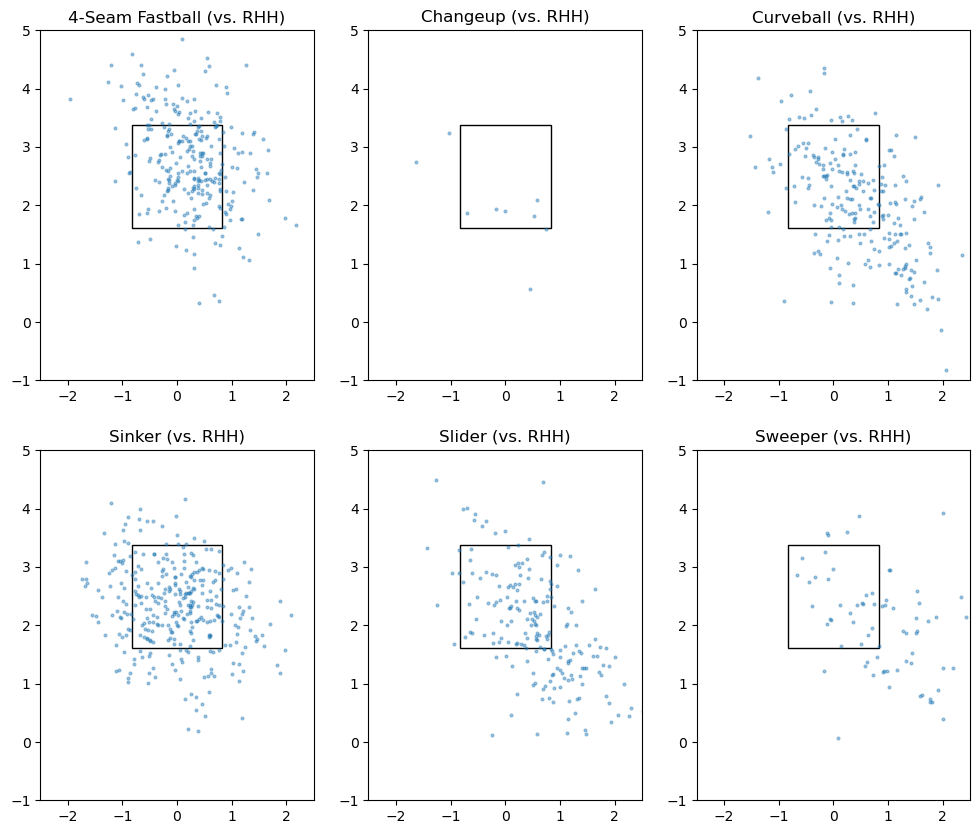

In [13]:
# plots where Lugo throws his pitches to right-handed hitters
groups = lugo.loc[lugo['stand']=='R', :].groupby('pitch_name')
fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=False)
axes = axes.flatten()

sz_top = lugo['sz_top'].mean()
sz_bot = lugo['sz_bot'].mean()

for i, (category, group) in enumerate(groups):
    axes[i].plot(group['plate_x'], group['plate_z'], marker = 'o', linestyle='', markersize=2, alpha=0.4, label=category)
    axes[i].set_title(f'{category} (vs. RHH)')
    axes[i].set_xlim(-2.5, 2.5)
    axes[i].set_ylim(-1, 5)
    axes[i].add_patch(patches.Rectangle((-0.83, sz_bot), 1.66, sz_top-sz_bot, linewidth=1, edgecolor='black', facecolor='none'))